<a href="https://colab.research.google.com/github/KevinHern/AI-Crash-Course/blob/main/AI_Crash_Course_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-Learning

[Presentation: AI Crash Course 10](https://view.genial.ly/61a6cafdd643fe0d915b1d32/presentation-ai-crashcourse10)

## 0) Preparations

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

## 1) Player Class Definition

In [18]:
# The player will only keep track of its score
class Player(object):
    def __init__(self):
        super(Player, self).__init__()
        self.score = 0

    def addToScore(self, card):
        self.score += card

    def isGameOver(self):
        return self.score > 21

    def reset(self):
        self.score = 0

## 2) Deck Class Definition

In [19]:
# It keeps track of what cards have been unused
class Deck(object):
    def __init__(self, num_cards):
        super(Deck, self).__init__()
        self.num_cards = num_cards
        self.cards = [4] * num_cards
        self.cards_played = 0
        self.turns = 0

    def getCard(self):
        card = random.randint(1, self.num_cards)
        while(self.cards[card-1] == 0):
            card = random.randint(1, self.num_cards)

        self.cards[card - 1] -= 1

        if card >= 11:
            return 10
        else:
            return card

    def nextRound(self):
        if self.cards_played < len(self.cards):
            self.turns += 1
            return true
        else:
            return false

    def reset(self):
        self.cards = [4] * self.num_cards
        self.cards_played = 0
        self.turns = 0

## 3) Q-Agent Class Definition

In [20]:
class QAgent(object):
    def __init__(self, num_states, actions, entity, epsilon, decay_epsilon,
                 discount=0.90, learning_rate=0.80, episodes=1000):
        super(QAgent, self).__init__()

        '''
        STATES:
            We will be working in a discrete world. The number of states equals to the different possible sums that the
            player can have (meaning from 2 up to 21) and an extra state that represents game over
            
        ACTIONS:
            The actions that the player can choose from are only 2: Stay (do not draw any card) or hit (draw a card)
        '''
        self.num_states = num_states
        self.actions = actions

        '''
        Q-TABLE INITIALIZATION:
            Lets start with over optimistic values. This is a method for the algorithm to learn the decision process.
            Sometimes having over optimistic values, allows the algorithm to really adjust what is truly profitable and
            what not.
            
            In this case, we will work with a Q-Table that only considers the current player's sum of cards. We won't
            take into consideration dealer awareness.
        '''
        self.q_table = [[100 for i in range(len(actions))] for j in range(num_states[0])] # [player_state, action]

        # The player object itself
        self.entity = entity

        # Algorithm Parameters
        self.discount = discount
        self.learning_rate = learning_rate

        '''
        POLICY TO USE: DECAY EPSILON
            This method consists of an evolutionary explore-exploit approach. The model will always explore in its
            first episodes but as 'time' progresses, it will switch to the exploit mindset, meaning it will always
            select the action that gives the maximum reward.
        '''
        self.epsilon = epsilon
        self.decay_epsilon = decay_epsilon

        # Metric to measure performance
        self.performance = 0

    # Get record the performance of the model
    def modifyPerformance(self, value, history):
        self.performance += value
        history += [self.performance]

    # This function performs the action selection of the agent. In this case, hit (draw) or stay
    def doAction(self, action, deck):
        if action == 0:
            return deck.getCard()
        elif action == 1:
            return 0
        else:
            raise Exception("Unreachable action")

    # This the function that updates the Q table.
    def updateQTable(self, action, reward, old_state, new_state=None):
        # This is the case that the Agent decided to stay
        if new_state is None:
            self.q_table[old_state][action] += self.learning_rate*(reward - self.discount*self.q_table[old_state][action])
        # This is the case that the Agent decided to hit
        else:
            self.q_table[old_state][action] += self.learning_rate*(reward + self.discount*self.q_table[new_state][np.argmax(self.q_table[new_state])] - self.q_table[old_state][action])

    def step(self, deck):
        # Epsilon greedy algorithm.
        p = np.random.random()
        action = 0
        if p < self.epsilon:
            # The agents chooses an action randomly to explore
            action = np.random.choice(len(self.actions))
        else:
            # The agent chooses the action that grants the highest Q-Value
            action = np.argmax(self.q_table[self.entity.score])

        # Perform action
        reward = self.doAction(action, deck)
        old_score = self.entity.score

        # Updating score
        self.entity.addToScore(reward)

        return [old_score, self.entity.score, action, 10]

## 4) BlackJack Game Class Definition

In [21]:
class BlackJack(object):
    """docstring for BlackJack"""
    def __init__(self, dealer, qagent, deck, num_games=20000):
        super(BlackJack, self).__init__()
        # The entities that are going to play
        self.dealer = dealer
        self.qagent = qagent
        self.deck = deck

        # Macro Variables
        self.num_games = num_games

        # Game related variables
        self.agent_games_won = 0
        self.dealer_games_won = 0

    def reset(self):
        self.deck.reset()
        self.qagent.entity.reset()
        self.dealer.reset()

    def serveAll(self):
        # The dealer gives a card to the player and draws a card that remains hidden
        self.qagent.entity.addToScore(card=self.deck.getCard())
        hidden_card = self.deck.getCard()

        # Then the dealer gives another card to the player and draws a card and is placed face up
        self.qagent.entity.addToScore(card=self.deck.getCard())
        self.dealer.addToScore(card=self.deck.getCard())

        # None knows what value the hidden card has
        return hidden_card

    def playerTurn(self, training):
        # Global variable to keep track if the player already lost or not
        player_busted = False

        # History: pair of (old_state, action) made through all the agent's turn
        player_history = []
        while True:
            # List of values to keep track of: old state, new state, action, reward
            player_values = []

            # Player 1's turn
            player_values = self.qagent.step(deck=self.deck)
            player_busted = self.qagent.entity.isGameOver()

            # Only update QTable when training
            if training:
                if player_busted:
                    # Punishing last action that lead to game over
                    player_values[3] = -15
                    self.qagent.updateQTable(old_state=player_values[0], new_state=None, action=player_values[2],
                                                reward=player_values[3])
                else:
                    # Giving a small reward for the player
                    self.qagent.updateQTable(old_state=player_values[0], new_state=player_values[1],
                                                action=player_values[2], reward=player_values[3])

                # Adding track of the actions
                player_history += [[player_values[0], player_values[2]]]

            if player_values[2] == 1 or player_busted:
                break

        return player_history, player_busted

    def dealerTurn(self, hidden_card):
        dealer_busted = False
        original_dealer_score = self.dealer.score
        self.dealer.addToScore(hidden_card)
        while self.dealer.score < 17:
            self.dealer.addToScore(self.deck.getCard())

            dealer_busted = self.dealer.isGameOver()
            if dealer_busted:
                break

        return dealer_busted, original_dealer_score

    def trackGames(self, qagent_games, dealer_games):
        dealer_games += [self.dealer_games_won]
        qagent_games += [self.agent_games_won]

    def play(self, training=True):
        agent_performance = []
        qagent_games = []
        dealer_games = []
        # Starting episodes of games
        for num_game in range(self.num_games):

            # Start serving
            hidden_card = self.serveAll()

            # If player goes bust or hits natural 21, continue
            if self.qagent.entity.score >= 21:
                self.reset()
                num_game -= 1
                continue

            # Player moves
            player_history, player_busted = self.playerTurn(training=training)

            # If player already busted, end game
            if player_busted:
                self.dealer_games_won += 1
                self.trackGames(qagent_games=qagent_games, dealer_games=dealer_games)
                print(
                    "Game {} results:\nAgent games won: {}\t Dealer games won: {}\nAgent Score: {}\tDealer Score: {}\nPlayer got busted!\n\n".format(
                        num_game + 1, self.agent_games_won, self.dealer_games_won, self.qagent.entity.score,
                        self.dealer.score))
                self.reset()
                self.qagent.modifyPerformance(value=-2, history=agent_performance)
                continue
            elif self.qagent.entity.score == 21:
                # Only update Q table during training
                if training:
                    # Reward the 2 last actions: Stand when hit 21 and whatever previous hit
                    self.qagent.updateQTable(old_state=player_history[-2][0], new_state=21, action=0,
                                                reward=15)  # Hit on the previous state
                    self.qagent.updateQTable(old_state=21, new_state=None, action=1, reward=15)  # Stand when hit 21

                self.agent_games_won += 1
                self.trackGames(qagent_games=qagent_games, dealer_games=dealer_games)
                print(
                    "Game {} results:\nAgent games won: {}\t Dealer games won: {}\nAgent Score: {}\tDealer Score: {}\nPlayer got natural 21!\n\n".format(
                        num_game + 1, self.agent_games_won, self.dealer_games_won, self.qagent.entity.score,
                        self.dealer.score))
                self.reset()
                self.qagent.modifyPerformance(value=2, history=agent_performance)
                continue

            # Dealer now moves
            dealer_busted, original_dealer_score = self.dealerTurn(hidden_card=hidden_card)

            # If dealer is busted, end game
            if dealer_busted:
                # Only update Q Table during training
                if training:
                    # Reward the last action that the agent did
                    self.qagent.updateQTable(old_state=player_history[-1][0], new_state=None, action=1, reward=5)

                self.agent_games_won += 1
                self.trackGames(qagent_games=qagent_games, dealer_games=dealer_games)
                self.qagent.modifyPerformance(value=0, history=agent_performance)
                print(
                    "Game {} results:\nAgent games won: {}\t Dealer games won: {}\nAgent Score: {}\tDealer Score: {}\nDealer got busted!\n\n".format(
                        num_game + 1, self.agent_games_won, self.dealer_games_won, self.qagent.entity.score,
                        self.dealer.score))
                self.reset()
                continue
            # Compare who won
            else:
                self.trackGames(qagent_games=qagent_games, dealer_games=dealer_games)
                if self.dealer.score > self.qagent.entity.score:
                    # Only update Qtable during training
                    if training:
                        # Punish the last action that the agent did (aka, stand)
                        self.qagent.updateQTable(old_state=player_history[-1][0], new_state=None, action=1,
                                                    reward=-15)

                    self.dealer_games_won += 1
                    self.qagent.modifyPerformance(value=-1, history=agent_performance)
                elif self.dealer.score < self.qagent.entity.score:
                    # Only update Qtable during training
                    if training:
                        # Reward all the actions
                        for i in range(len(player_history) - 1):
                            self.qagent.updateQTable(old_state=player_history[i][0],
                                                        new_state=player_history[i + 1][0], action=player_history[i][1],
                                                        reward=5)
                        self.qagent.updateQTable(old_state=player_history[-1][0], new_state=None, action=0,
                                                    reward=15)

                    self.agent_games_won += 1
                    self.qagent.modifyPerformance(value=1, history=agent_performance)
                else:
                    # Draw, nobody wins nor nobody loses
                    self.qagent.modifyPerformance(value=0, history=agent_performance)
                    pass

            # Print results
            print(
                "Game {} results:\nAgent games won: {}\t Dealer games won: {}\nAgent Score: {}\tDealer Score: {}\n\n".format(
                    num_game + 1, self.agent_games_won, self.dealer_games_won, self.qagent.entity.score,
                    self.dealer.score))

            self.reset()

            # Decrease Agent's epsilon during training
            if training:
                if self.qagent.epsilon > 0:
                    self.qagent.epsilon -= self.qagent.decay_epsilon

        self.qagent.performance = 0
        self.agent_games_won = 0
        self.dealer_games_won = 0
        return agent_performance, qagent_games, dealer_games

## 5) Training Q-Agent

In [22]:
# Macro variables
num_games = 30000
dealer_games_won = 0
agent_games_won = 0
epsilon = 1
decay_epsilon = 1 / (num_games / 2)

# Creating players
player = Player()
dealer = Player()

# Creating Agents
qagent = QAgent(num_states=[35, 35], actions=["Stay", "Pick"], entity=player, epsilon=epsilon,
                decay_epsilon=decay_epsilon, discount=0.80, learning_rate=0.80)

# Creating Deck of cards
deck = Deck(num_cards=13)

# Creating Game
blackJack = BlackJack(dealer=dealer, qagent=qagent, deck=deck, num_games=num_games)

# Games without Dealer Awareness
blackJack.qagent.epsilon = epsilon
training_performance, training_qagent_games, training_dealer_games = blackJack.play(training=True)

Streaming output truncated to the last 5000 lines.


Game 29077 results:
Agent games won: 9487	 Dealer games won: 18331
Agent Score: 18	Dealer Score: 17


Game 29078 results:
Agent games won: 9487	 Dealer games won: 18331
Agent Score: 18	Dealer Score: 18


Game 29079 results:
Agent games won: 9487	 Dealer games won: 18332
Agent Score: 13	Dealer Score: 19


Game 29080 results:
Agent games won: 9487	 Dealer games won: 18333
Agent Score: 30	Dealer Score: 7
Player got busted!


Game 29081 results:
Agent games won: 9488	 Dealer games won: 18333
Agent Score: 17	Dealer Score: 24
Dealer got busted!


Game 29082 results:
Agent games won: 9488	 Dealer games won: 18334
Agent Score: 12	Dealer Score: 19


Game 29083 results:
Agent games won: 9489	 Dealer games won: 18334
Agent Score: 19	Dealer Score: 22
Dealer got busted!


Game 29084 results:
Agent games won: 9489	 Dealer games won: 18335
Agent Score: 17	Dealer Score: 21


Game 29085 results:
Agent games won: 9489	 Dealer games won: 18335
Agent Sc

## 6) Show final Q-Table

Player has 2	Values: [22.519355310678883, -4.02950063010239]
Player has 3	Values: [22.21497291047078, -5.664112772605108]
Player has 4	Values: [21.136521280099405, -6.956076064691281]
Player has 5	Values: [4.398677446600441, -5.933004329212231]
Player has 6	Values: [4.053530825533589, -9.551889412021648]
Player has 7	Values: [14.306358395652222, 9.638532979374695]
Player has 8	Values: [16.624887706455585, -5.059269414539457]
Player has 9	Values: [4.002015363956861, -2.321943293553158]
Player has 10	Values: [0.4086119641662349, -6.1379331590986475]
Player has 11	Values: [33.54372697253225, -2.012086072023365]
Player has 12	Values: [-17.626485416926684, 4.391309702533878]
Player has 13	Values: [-18.490862875666615, -7.646500437718759]
Player has 14	Values: [-14.612168205216452, 5.022412661957468]
Player has 15	Values: [-17.347586032368582, -12.627140801675692]
Player has 16	Values: [-18.71005470357669, -13.016995392637702]
Player has 17	Values: [-18.749757796809053, -2.869134349588471]
P

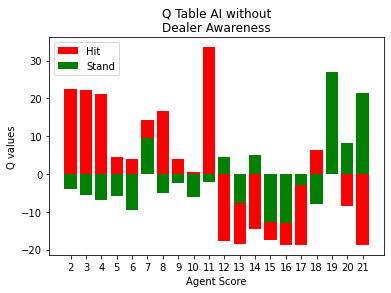

In [23]:
for i in range(20):
    print('Player has {}\tValues: {}'.format(i + 2, qagent.q_table[i + 2]))

# Show actual Qtable
tick_label = [i + 2 for i in range(20)]

# plotting a bar chart of Q values of Hit
plt.bar(tick_label, list(map(lambda x: x[0], qagent.q_table[2:22])), tick_label=tick_label,
        width=0.8, color=['red'], label='Hit')

# plotting a bar chart of Q values of Stand
plt.bar(tick_label, list(map(lambda x: x[1], qagent.q_table[2:22])), tick_label=tick_label,
        width=0.8, color=['green'], label='Stand')

plt.xlabel('Agent Score')
plt.ylabel('Q values')
plt.title('Q Table AI without\nDealer Awareness')
plt.legend()
plt.show()

## 7) Testing Q-Agent

In [24]:
test_performance, test_qagent_games, test_dealer_games = blackJack.play(training=False)

Streaming output truncated to the last 5000 lines.
Game 29075 results:
Agent games won: 11749	 Dealer games won: 15880
Agent Score: 20	Dealer Score: 24
Dealer got busted!


Game 29076 results:
Agent games won: 11750	 Dealer games won: 15880
Agent Score: 12	Dealer Score: 22
Dealer got busted!


Game 29077 results:
Agent games won: 11750	 Dealer games won: 15881
Agent Score: 14	Dealer Score: 17


Game 29078 results:
Agent games won: 11750	 Dealer games won: 15882
Agent Score: 12	Dealer Score: 17


Game 29079 results:
Agent games won: 11751	 Dealer games won: 15882
Agent Score: 15	Dealer Score: 24
Dealer got busted!


Game 29080 results:
Agent games won: 11751	 Dealer games won: 15883
Agent Score: 12	Dealer Score: 19


Game 29081 results:
Agent games won: 11752	 Dealer games won: 15883
Agent Score: 19	Dealer Score: 24
Dealer got busted!


Game 29082 results:
Agent games won: 11753	 Dealer games won: 15883
Agent Score: 19	Dealer Score: 18


Game 29083 results:
Agent games won: 11753	 Deale

## 8) Visualizing Performance

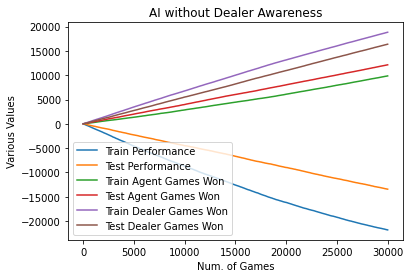

In [25]:
# Plotting the Training and Test metric performance
plt.plot([i + 1 for i in range(len(training_performance))], training_performance, label="Train Performance")
plt.plot([i + 1 for i in range(len(test_performance))], test_performance, label="Test Performance")

# Plotting Agent Games Won
plt.plot([i + 1 for i in range(len(training_qagent_games))], training_qagent_games, label="Train Agent Games Won")
plt.plot([i + 1 for i in range(len(test_qagent_games))], test_qagent_games, label="Test Agent Games Won")

# Plotting Dealer Games Won
plt.plot([i + 1 for i in range(len(training_dealer_games))], training_dealer_games, label="Train Dealer Games Won")
plt.plot([i + 1 for i in range(len(test_dealer_games))], test_dealer_games, label="Test Dealer Games Won")

plt.xlabel('Num. of Games')
plt.ylabel('Various Values')
plt.title('AI without Dealer Awareness')
plt.legend()
plt.show()